In [135]:
import numpy as np
import numpy.random as rnd
import collections
from enum import Enum

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [133]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [162]:
class Player():
    def __init__():
        return
    
    #return None to end turn
    def get_dices_to_roll(game_state):
        return None
    
    #ToDo: allow returning what to put in the chest

class Random_Player(Player):
    def __init__(self):
        self._p_end_turn = 0.3
        self._p_reroll = 0.33
        return
    
    #return Noneor empty array to end turn
    def get_dices_to_roll(self, game_state):
        if (rnd.rand() < self._p_end_turn):
            return None
        
        reroll = [i for i,v in enumerate(game_state.dice_values) if ((v != Dice_Values.SKULL) and (rnd.rand() < self._p_reroll))]
        return reroll
    
class Basic_Player(Player):
    def __init__(self):
        self.dice_values = None
        self.effective_dice_values = None
        self.card = None
        
    def init(self, current_dices, card):
        self.dice_values = current_dices
        self.card = card
        self.effective_dice_values = self.dice_values + Cards().to_dice_array(self.card)
    
    #return Noneor empty array to end turn
    def get_dices_to_roll(self, game_state):
        self.init(game_state.dice_values, game_state.card)
        reroll = []

        counts = collections.Counter(self.effective_dice_values)
        
        th = 3
        #ToDo: sorceress
        if (counts.get(Dice_Values.SKULL, 0) < 2):
            ungrouped = {k for k,v in counts.items() if v < th}
            reroll = [i for i,v in enumerate(self.dice_values) if v in ungrouped]
        #else, 2 (or more...) skulls: don't reroll
        
        
        return reroll    

p = Random_Player()
gs = Game_State(Dices().roll().get_current(), None)
p.get_dices_to_roll(gs)

p = Basic_Player()
g = Game()
card = g.get_card_from_deck()
dice_values = g.roll()

gs = Game_State(dice_values.get_current(), card)
print('dices: %s, reroll=%s' % (dice_values.get_current_as_str(), p.get_dices_to_roll(gs)))



    
    

dices: ['PARROT', 'PARROT', 'DIAMOND', 'MONKEY', 'MONKEY', 'COIN', 'PARROT', 'DIAMOND'], reroll=[2, 3, 4, 5, 7]


card=CAPTAIN, rolls = 4, history=[['PARROT', 'COIN', 'COIN', 'SWORD', 'PARROT', 'SWORD', 'DIAMOND', 'DIAMOND'], ['DIAMOND', 'DIAMOND', 'COIN', 'SWORD', 'PARROT', 'SWORD', 'DIAMOND', 'DIAMOND'], ['DIAMOND', 'DIAMOND', 'COIN', 'COIN', 'PARROT', 'DIAMOND', 'DIAMOND', 'DIAMOND'], ['SKULL', 'DIAMOND', 'COIN', 'SWORD', 'PARROT', 'DIAMOND', 'DIAMOND', 'DIAMOND'], ['SKULL', 'DIAMOND', 'COIN', 'SWORD', 'PARROT', 'DIAMOND', 'DIAMOND', 'DIAMOND']]
round score 1400
avg score: %.2f 384.5


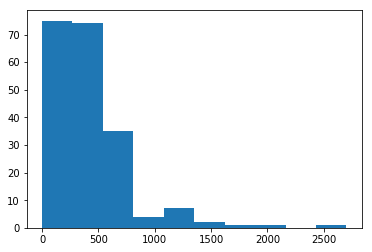

In [145]:
class Player_Turn():
    def __init__(self, game, player_idx, verbose=False):
        self.game = game
        self.player = game.players[player_idx]
        self.card = game.get_card_from_deck()
        self.rolls = 0
        self._skull_rerolls_remaining = self.get_allowed_skull_rerolls()
        self._skulls_to_end_of_turn = 3
        self._verbose = verbose
        
        self.dice_history = []
        
    def get_allowed_skull_rerolls(self):
        if (self.card == Card_Values.SORCERESS):
            return 1
        
        return 0
    
    #i.e. with card
    def get_effective_dice_values(self):        
        return self.game.dices.get_current() + Cards().to_dice_array(self.card)
            
    def has_turn_ended(self):
        dice_values = self.get_effective_dice_values()
        dice_counts = collections.Counter(dice_values)
        
        if (dice_counts.get(Dice_Values.SKULL, 0) - self._skull_rerolls_remaining > self._skulls_to_end_of_turn):
            return True
        
        return False
        
    #ToDo
    def is_valid_reroll(self, to_reroll):
        return True
    
    def play(self):
        self.game.dices.roll()
        
        self.dice_history.append(self.game.dices.get_current_as_str())
        if (self._verbose):
            print("dice=%s" % (self.game.dices.get_current_as_str()))
        
        #ToDo: handle island-of-the-dead
        turn_ended = self.has_turn_ended()
        
        while (not turn_ended):
            if (self._verbose):
                print('dbg: roll %d' % (self.rolls))
            game_state = Game_State(self.game.dices.get_current(), self.card)
            to_reroll = self.player.get_dices_to_roll(game_state)
            
            if ((to_reroll is None) or (len(to_reroll) == 0)):
                if (self._verbose):
                    print('dbg: endo of turn by player')
                turn_ended = True
            if (self.is_valid_reroll(to_reroll)):
                self.game.dices.roll(to_reroll)
                self.dice_history.append(self.game.dices.get_current_as_str())
                if (self._verbose):
                    print("reroll=%s, dice=%s" % (str(to_reroll), self.game.dices.get_current_as_str()))
                self.rolls += 1
            else:
                if (self._verbose):
                    print('dbg: error: invalid request to reroll (%s), ending turn' % (str(to_reroll)))
                turn_ended = True
                
        #turn ended
        score = Scoring(self.game.dices.get_current(), self.card).score()
        
        return score
        
    
    def to_string(self):
        return 'card=%s, rolls = %d, history=%s' % (self.card.name, self.rolls, self.dice_history)
        
g = Game()
# p = Random_Player()
trn = Player_Turn(g, 0)
score = trn.play()
# print(trn.dice_history)
print(trn.to_string())
print("round score %d" % (score))

all_scores = []
for i in range(200):
    g = Game()
    # p = Random_Player()
    trn = Player_Turn(g, 0)
    score = trn.play()
    all_scores.append(score)
    
p = plt.hist(all_scores)
print('avg score: %.2f', np.average(all_scores))

    

        

In [64]:
trn

In [18]:
class Game_State():
    def __init__(self, dice_values, card):
        self.dice_values = dice_values
        self.card = card

In [151]:
class Game():
    def __init__(self, players = 2):        
        self._dice_count = 8
        
        self.player_count = players
        self.scores = [0] * players
        self.turn = 0
                
        self.dices = Dices(self._dice_count)
        self.players = self.create_players(players)
        
        self._goal = 8000
        self._current_player_rolls = 0
        
    def create_players(self, count):
        return [Random_Player() for x in range(count)]
        
    def get_card_from_deck(self):
        #ToDo: make it better
        card_values = [x for x in Card_Values]
        return card_values[rnd.choice(len(card_values))]
    
    def roll(self, indexes = None):
        return self.dices.roll(indexes)
    
    def to_string(self):
        return 'turns: %d, scores: %s' % (self.turn, self.scores)
    
#     def play():
        

    

In [149]:
class Card_Values(Enum):
        SORCERESS = 0
        PARROTS_AND_MONKEYS = 1
        CAPTAIN = 2
        SEA_BATTLE = 3
        COIN = 4
        DIAMOND = 5
        SKULL = 6
        TWO_SKULLS = 6
        CHEST = 7
        
class Cards():
    def __init__(self):        
        self.card_to_dice = {Card_Values.COIN: [Dice_Values.COIN], 
                                 Card_Values.DIAMOND: [Dice_Values.DIAMOND],
                                 Card_Values.SKULL: [Dice_Values.SKULL], 
                                 Card_Values.TWO_SKULLS: [Dice_Values.SKULL, Dice_Values.SKULL]}
   
    def to_dice_array(self, card):
        return self.card_to_dice.get(card, [])
    
    
    

In [53]:
class Dice_Values(Enum):
    SKULL = 0
    COIN = 1
    DIAMOND = 2
    PARROT = 3
    MONKEY = 4
    SWORD = 5

class Dices():
    def __init__(self, count = 8):
        self.dice_count = count
        self.dice_values = [None] * count
        self.skulls_rerolled = 0
        
        self._all_dice_vals = [d for d in Dice_Values]
        
    
    def get_current(self):
        #return a copy
        return [x for x in self.dice_values]
    
    def get_current_as_str(self):
        #return a copy
        return [x.name for x in self.dice_values]
    
    def roll(self, indexes = None):
        if (indexes is None):
            indexes = range(self.dice_count)
        
        for idx in indexes:
            if (self.dice_values[idx] == Dice_Values.SKULL):
                self.skulls_rerolled += 1
                
            v = self._single_roll()
            self.dice_values[idx] = v
            
        return self
    
    def _single_roll(self):        
        return self._all_dice_vals[rnd.choice(6)]    
    
    def to_string(self):
        return '%s' % (str([x.name for x in self.get_current()]))



#test partial roll
d = Dices()

idx = [0,1,2,4]
anti_idx = [x for x in range(8) if x not in idx]
for i in range(10):
    vals = d.roll().get_current()
    partial_roll = d.roll(idx).get_current()
    assert all([vals[i] == partial_roll[i] for i in anti_idx ])



In [9]:
d.roll().get_current_as_str()

['SWORD', 'SWORD', 'DIAMOND', 'SWORD', 'MONKEY', 'SKULL', 'MONKEY', 'PARROT']

In [107]:
class Scoring():
    def __init__(self, dice_values, card = None, dice_count = 8):
        
        self.dice_values = self._convert_dices_to_enum(dice_values)
        self.card = self._convert_card_to_enum(card)
        self._dice_count = dice_count
        
        self._scores_by_count = {3: 100, 4: 200, 5: 500, 6: 1000, 7: 2000, 8: 4000}
        self._full_chest = 500
        self._valuables = {Dice_Values.COIN: 100, Dice_Values.DIAMOND: 100}
        self._dice_used = set() #used for full-chest scoring
    
    def _convert_dices_to_enum(self, dice_values):
        return [x if x in Dice_Values else Dice_Values[x.upper()] for x in dice_values]
    
    def _convert_card_to_enum(self, card):
        if (card is None):
            return None
        
        return card if card in Card_Values else Card_Values[card.upper()]
        
    def _add_card_to_dice(self):
        return self.dice_values + Cards().to_dice_array(self.card)
        
    def is_disqualified(self):
        return len([x for x in self.dice_values if x == Dice_Values.SKULL]) >= 3
        
    def score(self):
        self.dice_values = self._add_card_to_dice()
        
        if (self.is_disqualified()):
            return 0
            
        score = self._score_by_groups() \
                + self._score_by_valuables() \
                + self._score_by_full_chest() \
                + self._score_by_sea_battle()
                
        
        coef = 2. if (self.card == Card_Values.CAPTAIN) else 1.
        
        return coef * score
    
    def _score_by_valuables(self):
        dice_used = {i for i,v in enumerate(self.dice_values) if v in self._valuables}
        self._dice_used |= dice_used
        
        return sum([self._valuables.get(x, 0) for x in self.dice_values])
    
    def _score_by_groups(self):
        
        if (self.card == Card_Values.PARROTS_AND_MONKEYS):
            self.dice_values = [Dice_Values.MONKEY if x == Dice_Values.PARROT else x for x in self.dice_values]
                    
        counts = collections.Counter(self.dice_values)
        groups_used = {k: v for k,v in counts.items() if v >= 3}
        dice_used = {i for i,v in enumerate(self.dice_values) if v in groups_used}
        self._dice_used |= dice_used        
        
        return sum([self._scores_by_count.get(v, 0) for k,v in counts.items()])
    
    #must be called after other scoring methods
    def _score_by_full_chest(self):
        if (len(self._dice_used) >= self._dice_count):
            return self._full_chest
        
        return 0
    
    #should be here? not sure.
    def _score_by_sea_battle(self):
        #ToDo
        return 0
        



#nothing
assert Scoring(['parrot', 'parrot', 'monkey', 'monkey']).score() == 0.0
#parrots and monkeys
assert Scoring(['parrot', 'parrot', 'monkey', 'monkey'], 'parrots_and_monkeys').score() == 200.0
#captain
assert Scoring(['sword', 'sword', 'sword', 'sword'], 'captain').score() == 400.0
#coin, diamond
assert Scoring(['sword', 'sword', 'sword', 'sword', 'diamond', 'coin'], 'captain').score() == 800.0
#skulls
assert Scoring(['sword', 'sword', 'skull', 'sword', 'skull', 'coin', 'skull'], 'captain').score() == 0.0
#full chest control
assert Scoring(['sword', 'sword', 'sword', 'sword', 'coin', 'coin', 'diamond', 'monkey'], None).score() == 500.0
#Full chest
assert Scoring(['sword', 'sword', 'sword', 'sword', 'coin', 'coin', 'diamond', 'diamond'], None).score() == 1100.0

In [11]:
g = Game()
g.to_string()

'# scores: [0, 0]'